### SatelliteBench

* [Dataset](https://physionet.org/content/multimodal-satellite-data/1.0.0/)

* [Paper](https://arxiv.org/abs/2401.11114)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import process_labels, split_data
from src.classifiers_base import preprocess_df

from transformers import BertTokenizer

from src.multimodal_data_loader import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_base import train_early_fusion, train_late_fusion

In [2]:
PATH = 'datasets/satellitedata/'

In [3]:
text_path = os.path.join(PATH, 'labels.csv')
images_path = os.path.join(PATH, 'images')

## Get data

In [4]:
df = pd.read_csv(text_path)
df.Labels = df.Labels.astype(str)
df

,image_id,text,Labels,split
0,5360_2016-10-23.jpg,"In a city with 2 Dengue classification, 4.83% ...",2,train
1,73001_2017-03-26.jpg,"In a city with 0 Dengue classification, 5.92% ...",0,train
2,50001_2018-01-28.jpg,"In a city with 1 Dengue classification, 6.82% ...",1,train
3,23001_2018-07-29.jpg,"In a city with 2 Dengue classification, 7.76% ...",2,train
4,54001_2016-01-17.jpg,"In a city with 2 Dengue classification, 7.04% ...",2,train
...,...,...,...,...
1555,5001_2018-08-05.jpg,"In a city with 0 Dengue classification, 5.16% ...",0,test
1556,68001_2017-05-21.jpg,"In a city with 0 Dengue classification, 6.22% ...",0,test
1557,8001_2018-04-08.jpg,"In a city with 0 Dengue classification, 7.08% ...",0,test
1558,8001_2016-03-06.jpg,"In a city with 0 Dengue classification, 7.08% ...",0,test


## Data Perparation

In [5]:
# Select features and labels vectors
text_columns = 'text'
image_columns = 'image_id'
label_columns = 'Labels'

df = preprocess_df(df, image_columns, images_path)

# Split the data
train_df, test_df = split_data(df)

# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)

100%|██████████| 1560/1560 [00:00<00:00, 3544.07it/s]


Train Shape: (936, 4)
Test Shape: (312, 4)


In [6]:
train_df

,image_id,text,Labels,split
0,datasets/satellitedata/images/5360_2016-10-23.jpg,"In a city with 2 Dengue classification, 4.83% ...",2,train
1,datasets/satellitedata/images/73001_2017-03-26...,"In a city with 0 Dengue classification, 5.92% ...",0,train
2,datasets/satellitedata/images/50001_2018-01-28...,"In a city with 1 Dengue classification, 6.82% ...",1,train
3,datasets/satellitedata/images/23001_2018-07-29...,"In a city with 2 Dengue classification, 7.76% ...",2,train
4,datasets/satellitedata/images/54001_2016-01-17...,"In a city with 2 Dengue classification, 7.04% ...",2,train
...,...,...,...,...
931,datasets/satellitedata/images/73001_2017-08-06...,"In a city with 1 Dengue classification, 5.92% ...",1,train
932,datasets/satellitedata/images/23001_2016-07-24...,"In a city with 0 Dengue classification, 7.76% ...",0,train
933,datasets/satellitedata/images/5001_2018-12-23.jpg,"In a city with 0 Dengue classification, 5.16% ...",0,train
934,datasets/satellitedata/images/73001_2016-10-09...,"In a city with 2 Dengue classification, 5.92% ...",2,train


In [7]:
# Instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### Models

In [9]:
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
The number of parameters of the model are: 197379
Epoch 1/15 - Test Accuracy: 0.5962, macro-f1: 0.5987
Epoch 1/15 - Training Time: 30.32 seconds | Inference Time: 9.86 seconds
Epoch 2/15 - Test Accuracy: 0.5609, macro-f1: 0.4098
Epoch 2/15 - Training Time: 28.96 seconds | Inference Time: 9.25 seconds
Epoch 3/15 - Test Accuracy: 0.7949, macro-f1: 0.7679
Epoch 3/15 - Training Time: 28.88 seconds | Inference Time: 9.45 seconds
Epoch 4/15 - Test Accuracy: 0.9038, macro-f1: 0.8874
Epoch 4/15 - Training Time: 29.34 seconds | Inference Time: 9.40 seconds
Epoch 5/15 - Test Accuracy: 0.6795, macro-f1: 0.5831
Epoch 5/15 - Training Time: 29.49 seconds | Inference Time: 9.39 seconds
Epoch 6/15 - Test Accuracy: 0.8750, macro-f1: 0.8551
Epoch 6/15 - Training Time: 30.11 seconds | Inference Time: 9.55 seconds
Epoch 7/15 - Test Accuracy: 0.8622, macro-f1: 0.8372
Epoch 7/15 - Training Time: 29.56 seconds | Inference Time: 9.36 seconds
Epoch 8/15 - Test Accuracy: 0.9231, mac

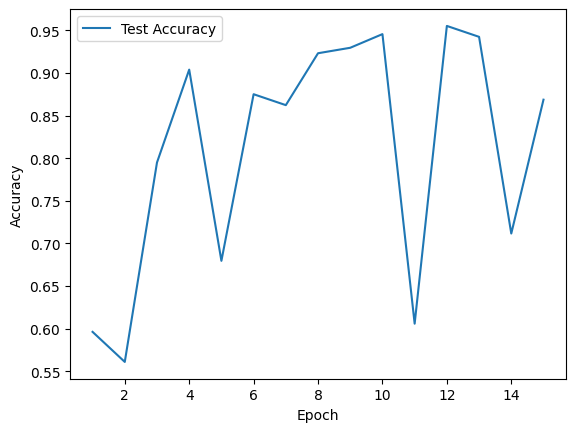

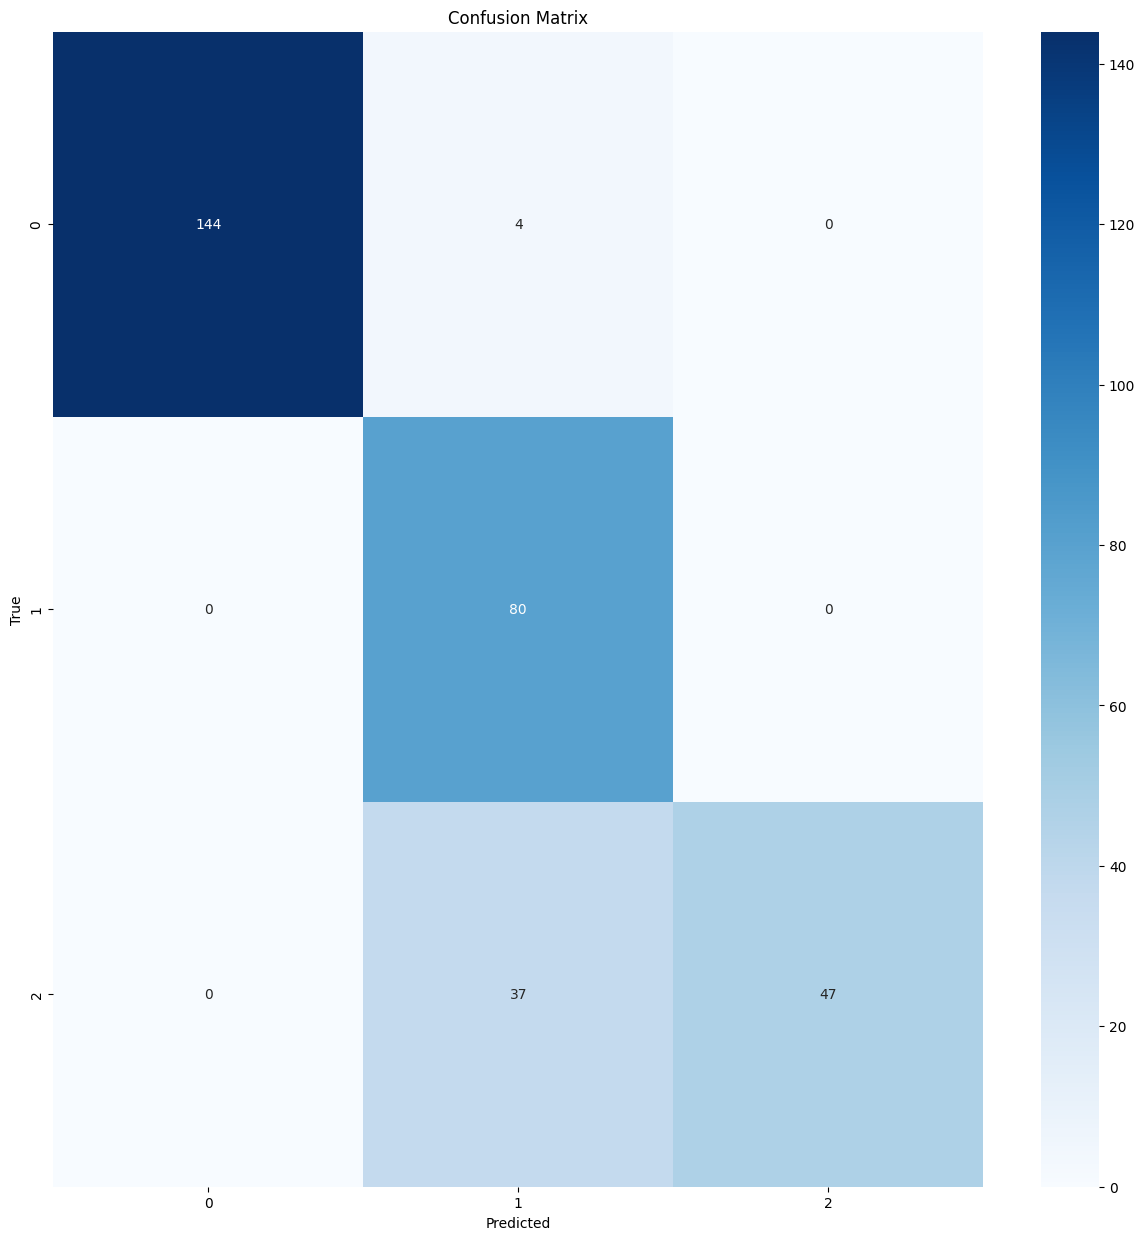

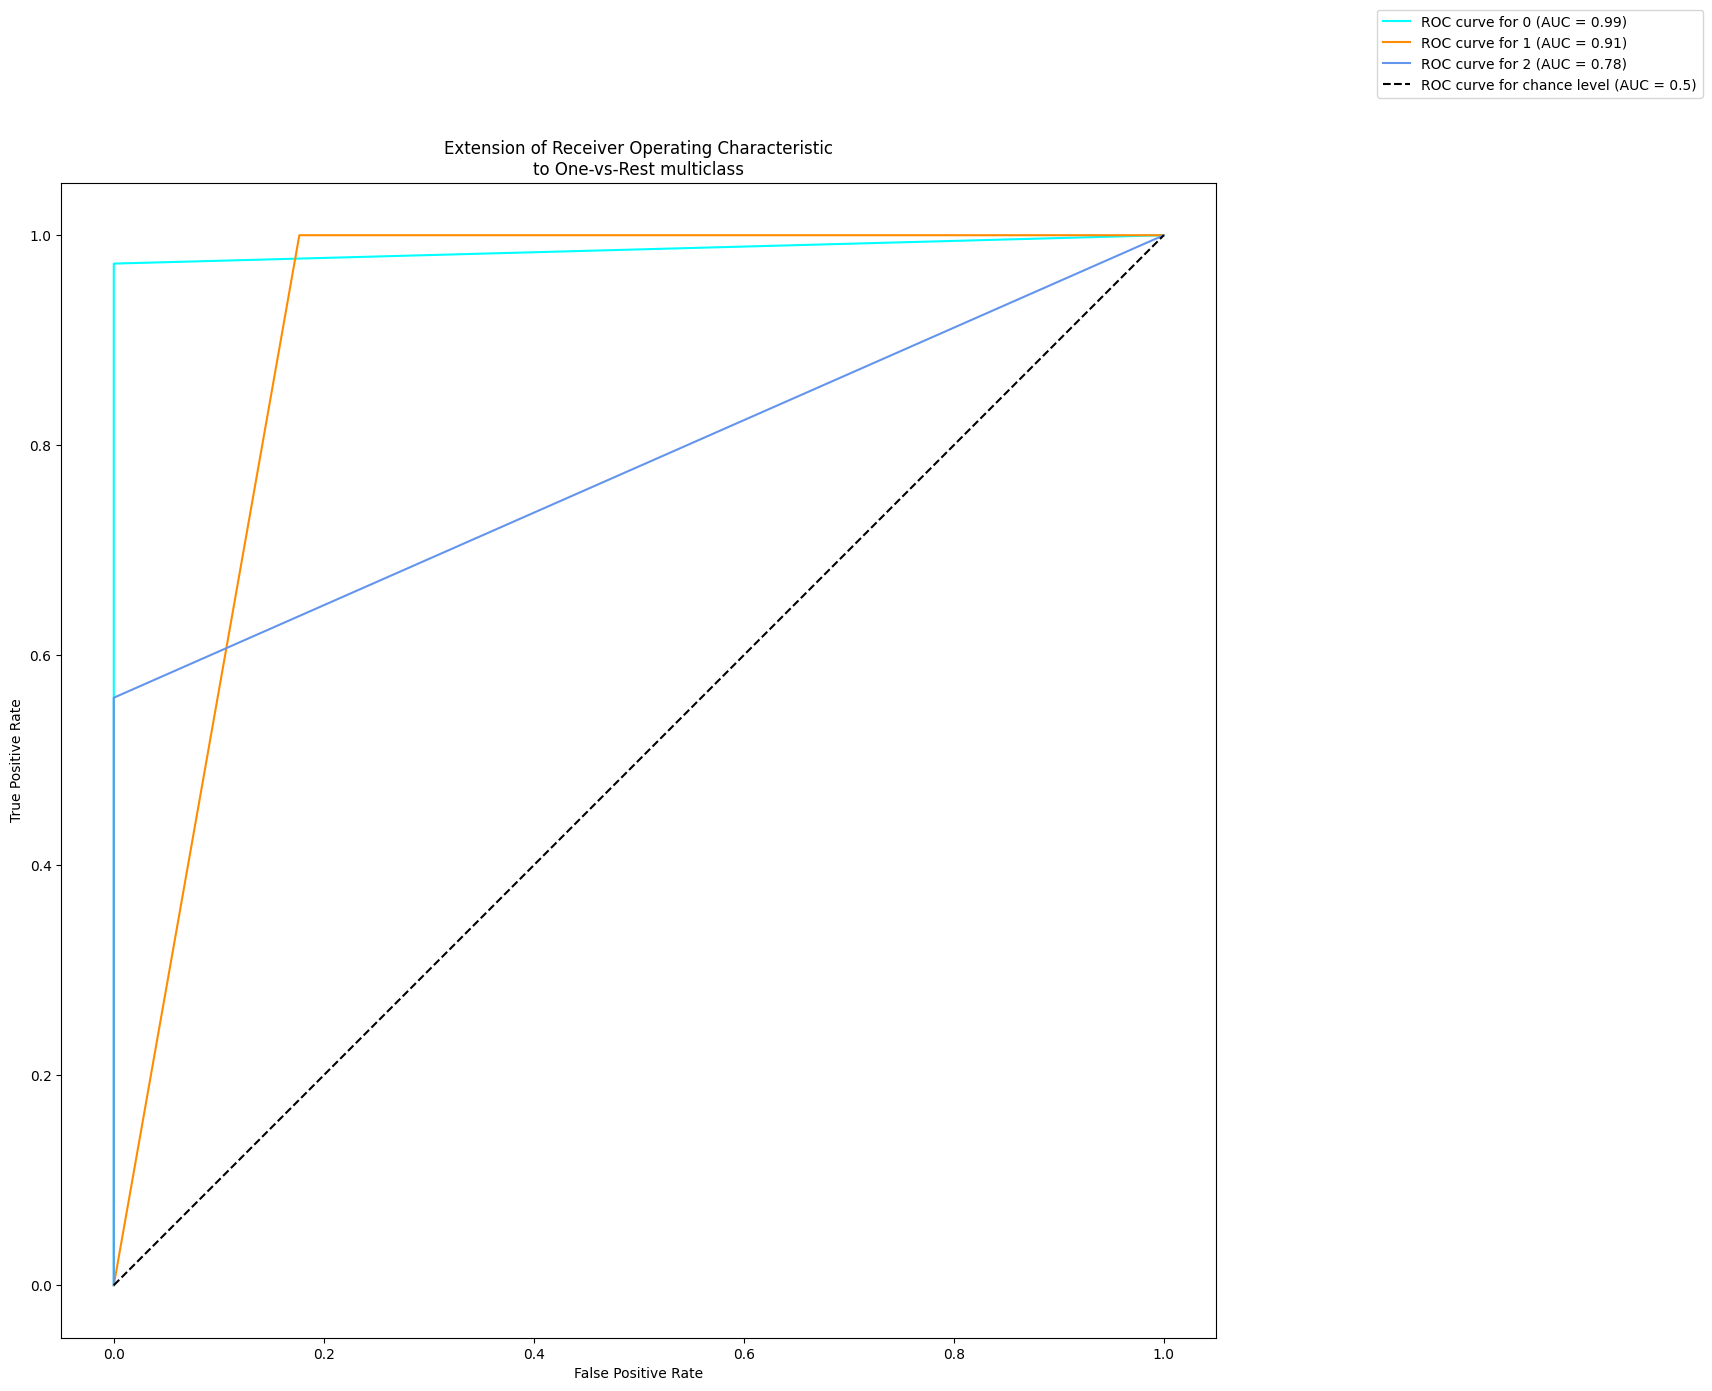

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       148
           1       0.66      1.00      0.80        80
           2       1.00      0.56      0.72        84

    accuracy                           0.87       312
   macro avg       0.89      0.84      0.83       312
weighted avg       0.91      0.87      0.87       312



In [10]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, output_size, num_epochs=15, multilabel=multilabel, report=True, lr=0.001, freeze_backbone=True)

Training Late Fusion Model:
The number of parameters of the model are: 99075
Epoch 1/15 - Test Accuracy: 0.6603, macro-f1: 0.5496
Epoch 1/15 - Training Time: 32.81 seconds | Inference Time: 10.21 seconds
Epoch 2/15 - Test Accuracy: 0.5288, macro-f1: 0.4428
Epoch 2/15 - Training Time: 29.85 seconds | Inference Time: 9.94 seconds
Epoch 3/15 - Test Accuracy: 0.7692, macro-f1: 0.7376
Epoch 3/15 - Training Time: 30.19 seconds | Inference Time: 9.67 seconds
Epoch 4/15 - Test Accuracy: 0.6603, macro-f1: 0.5696
Epoch 4/15 - Training Time: 30.71 seconds | Inference Time: 10.39 seconds
Epoch 5/15 - Test Accuracy: 0.8846, macro-f1: 0.8683
Epoch 5/15 - Training Time: 30.06 seconds | Inference Time: 10.26 seconds
Epoch 6/15 - Test Accuracy: 0.8429, macro-f1: 0.8198
Epoch 6/15 - Training Time: 30.36 seconds | Inference Time: 10.36 seconds
Epoch 7/15 - Test Accuracy: 0.8974, macro-f1: 0.8769
Epoch 7/15 - Training Time: 30.36 seconds | Inference Time: 9.61 seconds
Epoch 8/15 - Test Accuracy: 0.7853, m

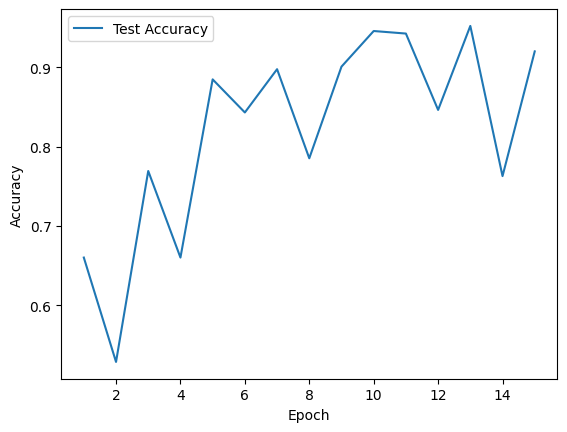

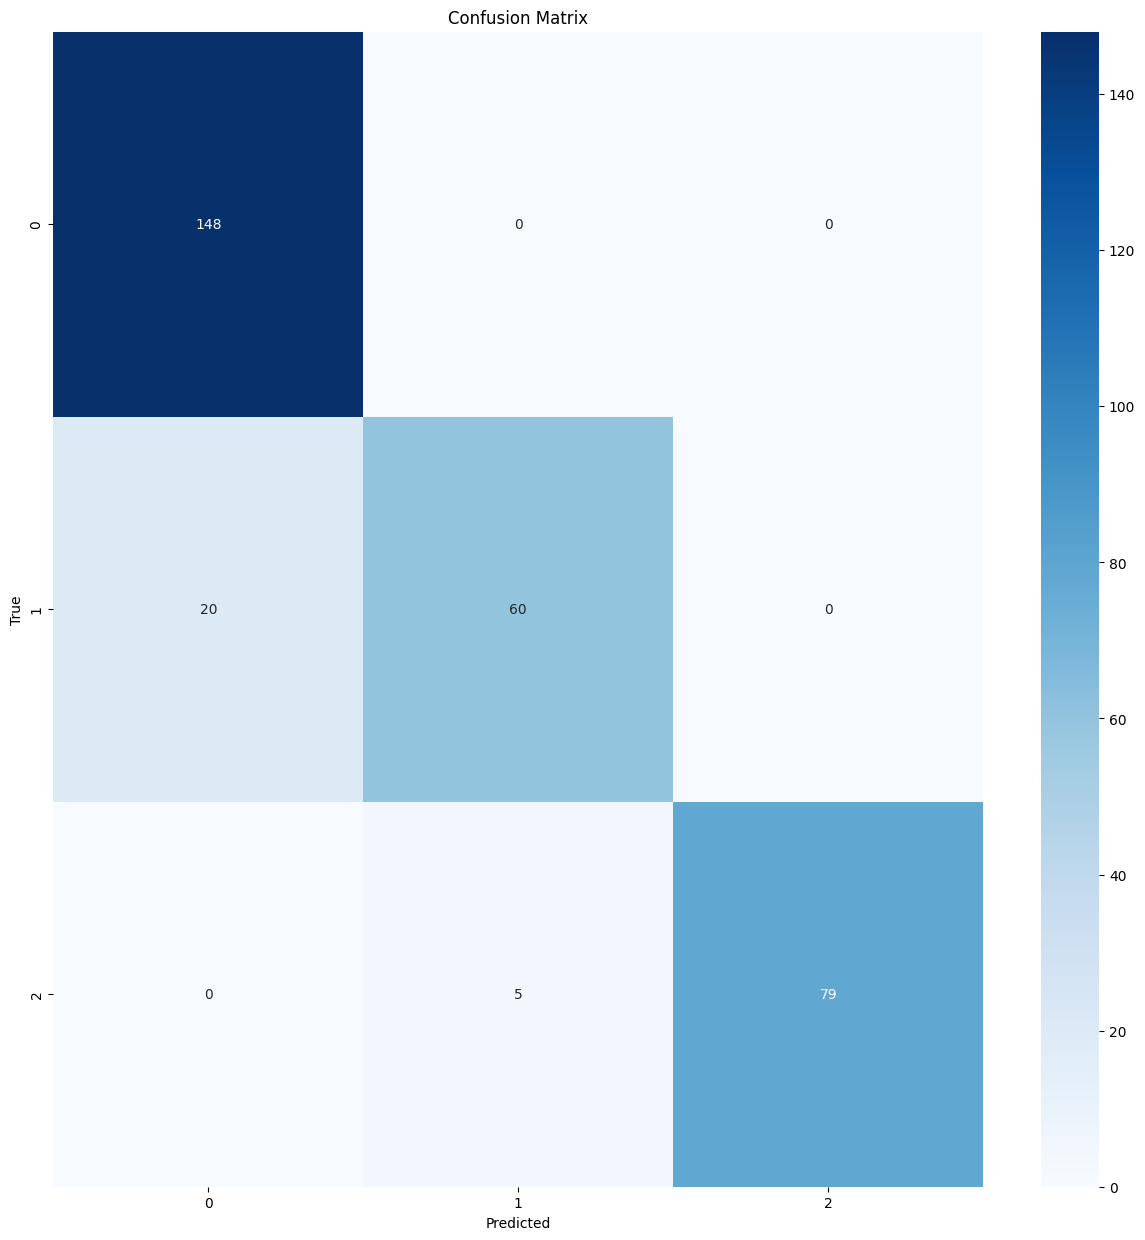

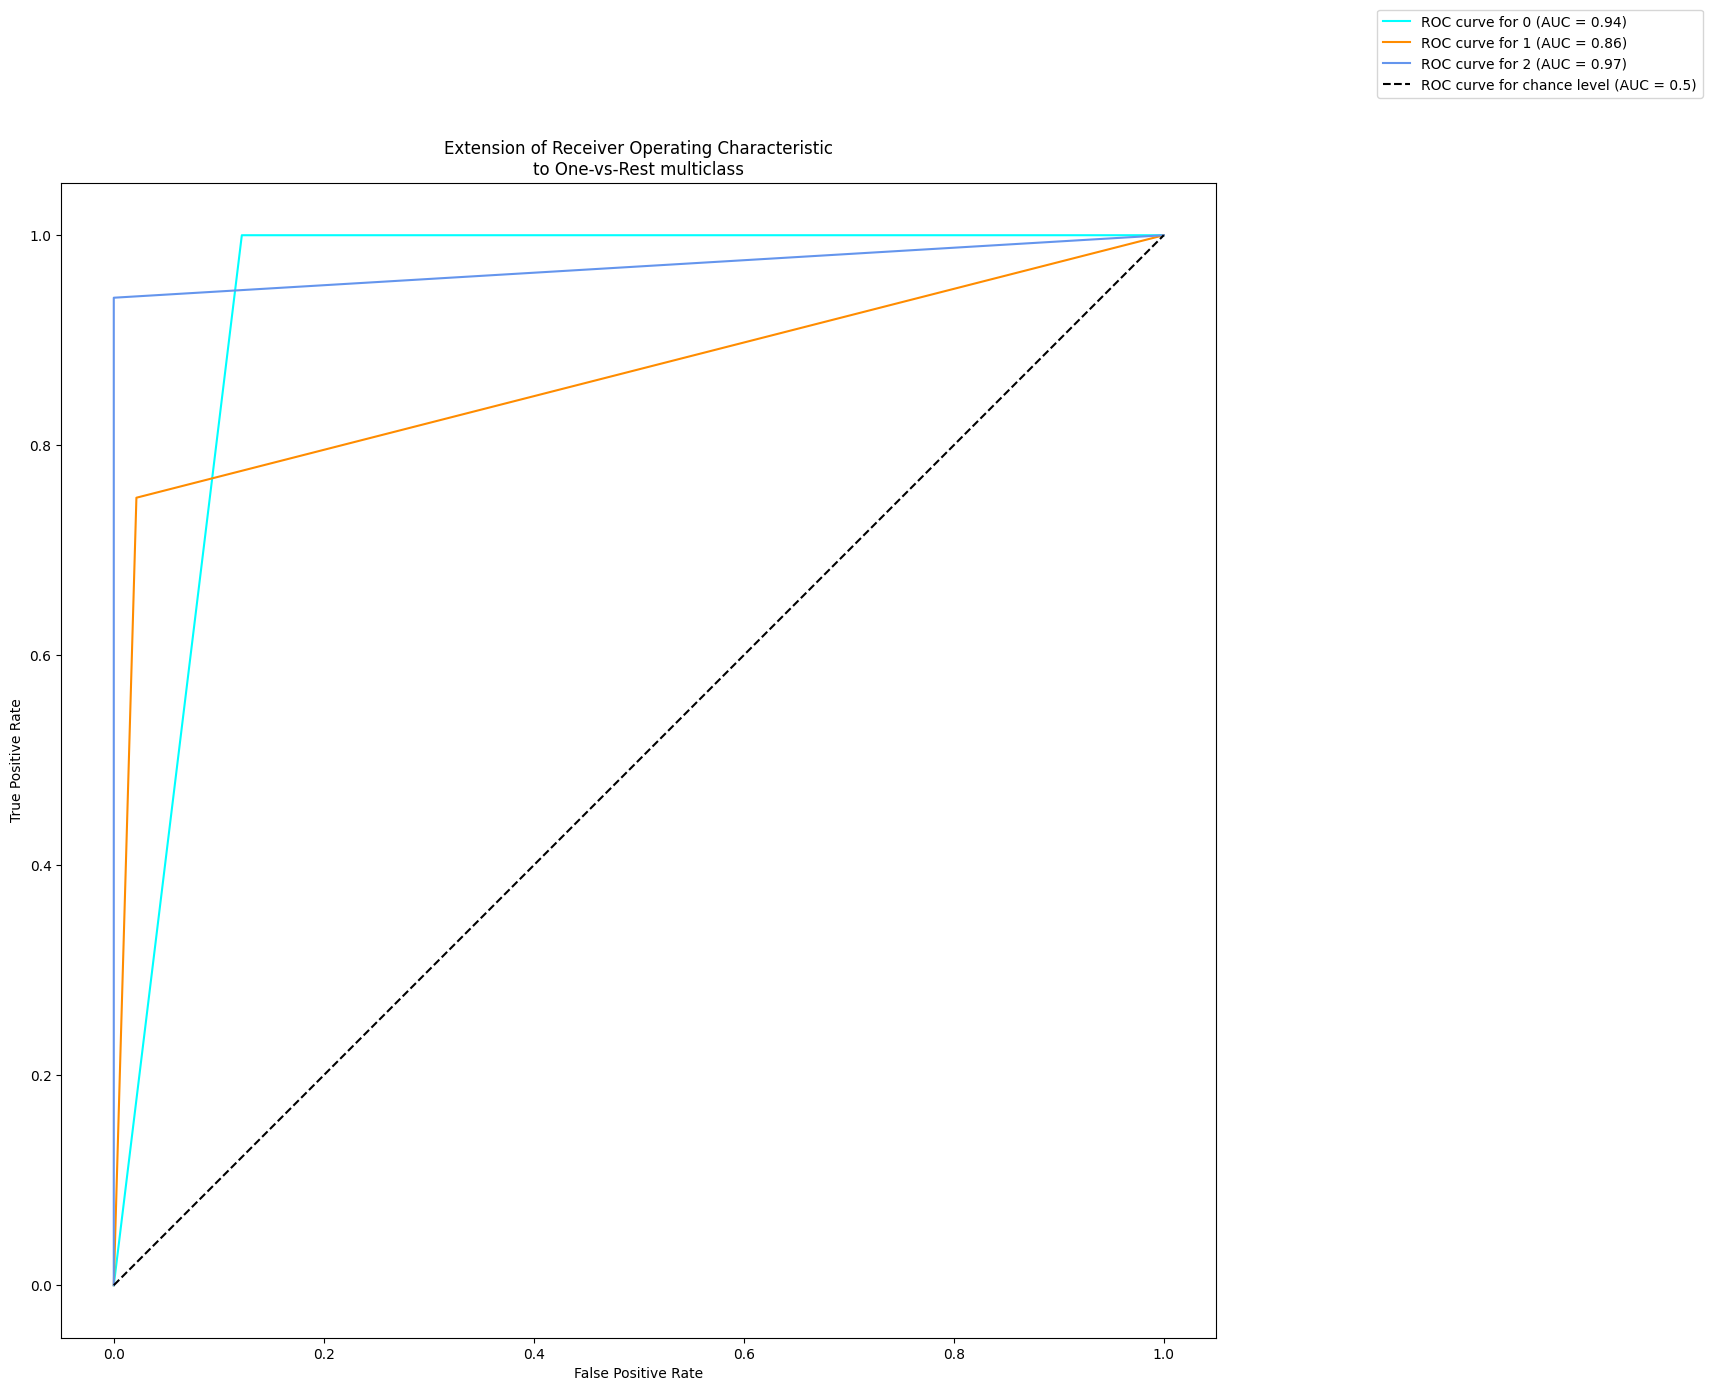

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       148
           1       0.92      0.75      0.83        80
           2       1.00      0.94      0.97        84

    accuracy                           0.92       312
   macro avg       0.93      0.90      0.91       312
weighted avg       0.92      0.92      0.92       312



In [11]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, output_size, num_epochs=15, multilabel=multilabel, report=True, freeze_backbone=True)